In [1]:
import tensorflow as tf

# load model with tricks
new_model = tf.keras.models.load_model('saved_model/best_binaryclassf_withtricks')

# load model
basic_model = tf.keras.models.load_model('saved_model/best_basic_binaryclassf')

In [2]:
import pandas as pd
import numpy as np

def append_ext(fn):
    return fn+".jpg"

traindf=pd.read_csv('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Part3_GroundTruth.csv',dtype=str)
testdf=pd.read_csv('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Part3_GroundTruth.csv',dtype=str)
traindf['image_id']=traindf['image_id'].apply(append_ext)
testdf['image_id']=testdf['image_id'].apply(append_ext)

In [3]:
#create a label column
label=[0]*traindf.shape[0]
for i in range(traindf.shape[0]):
    if traindf['melanoma'][i] == '1.0':
        label[i]='1'
    else:
        label[i]='0'
traindf['label']=label    

label=[0]*testdf.shape[0]
for i in range(testdf.shape[0]):
    if testdf['melanoma'][i] == '1.0':
        label[i]='1'
    else:
        label[i]='0'
testdf['label']=label

In [4]:
from sklearn.model_selection import train_test_split

X = traindf.loc[:,'image_id']
y = traindf.loc[:,'label']

train_x, val_x, train_y, val_y = train_test_split(X, y, 
                                                  test_size = 0.2, 
                                                  random_state = 27, 
                                                  stratify=y)

In [5]:
from imblearn.over_sampling import RandomOverSampler
train_x_overs, train_y_overs = RandomOverSampler(random_state=42, sampling_strategy='minority').fit_resample(train_x.values.reshape(train_x.shape[0],-1), train_y)

In [6]:
from keras_preprocessing.image import ImageDataGenerator

#a function to shuffle data and then build alternately (1 row melanoma, 1 non-melanoma and so-on)
def shuffle_sortdataframe(train_x, train_y, IMG_SIZE):
    #Training Dataframe 
    train_df = pd.DataFrame(data=np.column_stack((train_x,train_y)),columns=['image_id','label'])

    #Shuffle Dataframe rows
    train_df = train_df.sample(frac=1, axis=0).reset_index(drop=True)

    #Dataframe with non-melanoma samples only
    grouped = train_df.groupby(train_df.label) 
    df_new = grouped.get_group('0') 
    #print(df_new) 

    #Dataframe with melanoma samples only
    groupedM = train_df.groupby(train_df.label) 
    df_newM = groupedM.get_group('1') 
    #print(df_newM) 

    #Concatenate both dataframes alternately
    df_train_upsampled = pd.concat([df_new.reset_index(drop=True), df_newM.reset_index(drop=True)]).sort_index()
    #print(df_train_upsampled)


    train_datagen=ImageDataGenerator(rotation_range=5,  # rotation
                                 width_shift_range=0.2,  # horizontal shift
                                 zoom_range=0.2,  # zoom
                                 horizontal_flip=True,  # horizontal flip
                                 brightness_range=[0.2,0.8] # brightness
                                 #rescale=1./255.
                                )  

    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_upsampled,
                                            directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Data\\',
                                            x_col='image_id',
                                            y_col='label',
                                            batch_size=16,
                                            seed=42,
                                            shuffle=False,
                                            class_mode='binary',
                                            drop_duplicates = False,
                                            target_size=(IMG_SIZE,IMG_SIZE)
                                           )

    return train_generator

IMG_SIZE = 300 #B3
train_generator=shuffle_sortdataframe(train_x=train_x_overs, train_y=train_y_overs, IMG_SIZE=IMG_SIZE)

Found 2602 validated image filenames belonging to 2 classes.


In [7]:
#evaluate basic model on training set
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
basic_model.evaluate(train_generator,
               steps=STEP_SIZE_TRAIN)

162/162 [==============================] - 797s 5s/step - loss: 0.5102 - accuracy: 0.7431


[0.5101737380027771, 0.7430555820465088]

In [8]:
#evaluate model with tricks on training set
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
new_model.evaluate(train_generator,
               steps=STEP_SIZE_TRAIN)

162/162 [==============================] - 792s 5s/step - loss: 0.2769 - accuracy: 0.8843


[0.2769319415092468, 0.8842592835426331]

In [9]:
#Validation Dataframe
df_val= pd.DataFrame(columns=['image_id','label'])
df_val['image_id'] = val_x
df_val['label'] = val_y

valid_datagen=ImageDataGenerator()#rescale=1./255.)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=df_val,
                                            directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Data\\',
                                            x_col='image_id',
                                            y_col='label',
                                            batch_size=16,
                                            seed=42,
                                            shuffle=False,
                                            class_mode='binary',
                                            target_size=(IMG_SIZE,IMG_SIZE)
                                           )

#evaluate model with tricks on validation set
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
new_model.evaluate(valid_generator,
               steps=STEP_SIZE_VALID)

Found 400 validated image filenames belonging to 2 classes.
25/25 [==============================] - 108s 4s/step - loss: 0.4768 - accuracy: 0.8100


[0.4768308699131012, 0.8100000023841858]

In [15]:
#Make predictions on test set
test_datagen=ImageDataGenerator()#rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(dataframe=testdf,
                                                directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Data\\',
                                                x_col='image_id',
                                                y_col='label',
                                                batch_size=15,
                                                seed=42,
                                                shuffle=False,
                                                class_mode='binary',
                                                target_size=(IMG_SIZE,IMG_SIZE)
                                               )

test_generator.reset()
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

pred_basic=basic_model.predict(test_generator,
                   steps=STEP_SIZE_TEST,
                   verbose=1)

pred=new_model.predict(test_generator,
                   steps=STEP_SIZE_TEST,
                   verbose=1)

Found 600 validated image filenames belonging to 2 classes.
40/40 [==============================] - 347s 9s/step


AUC Score - Model with Tricks: 0.7567199306329742
AUC Score - Basic Model: 0.7758666454318629


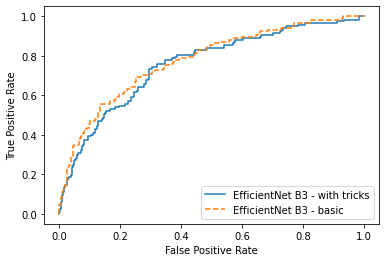

Best Threshold Value = 0.131671 


In [11]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, threshold = roc_curve(testdf['label'].astype(int).to_numpy(), pred)
roc_auc = metrics.auc(fpr, tpr)
print('AUC Score - Model with Tricks: ' + str(roc_auc))

fprB, tprB, thresholdB = roc_curve(testdf['label'].astype(int).to_numpy(), pred_basic)
roc_aucB = metrics.auc(fprB, tprB)
print('AUC Score - Basic Model: ' + str(roc_aucB))

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='-', label='EfficientNet B3 - with tricks')
plt.plot(fprB, tprB, linestyle='--', label='EfficientNet B3 - basic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


#precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testdf['label'].astype(int).to_numpy(), pred_basic)

# plot the roc curve for the model
#plt.plot(precision, recall, linestyle='--', label='EfficientNet B3 - basic')
# axis labels
#plt.xlabel('Recall')
#plt.ylabel('Precision')
# show the legend
#plt.legend()
# show the plot
#plt.show()

gmeans = np.sqrt(tpr * (1-fpr))
gmeansB = np.sqrt(tprB * (1-fprB))
# locate the index of the largest g-mean
if np.max(gmeans)>np.max(gmeansB):
    ix = np.argmax(gmeans)
    pred=pred
else:
    ix = np.argmax(gmeansB)
    pred=pred_basic

print('Best Threshold Value = %f ' % (threshold[ix]))

In [12]:
labels_pred=np.where(pred > threshold[ix], 1, 0)

In [13]:
import sklearn
acc=sklearn.metrics.accuracy_score(testdf['label'].astype(int).to_numpy(), labels_pred)
print('Accuracy: \n' + str(acc))

confusion_matrix=sklearn.metrics.confusion_matrix(testdf['label'].astype(int).to_numpy(), labels_pred)
print('\n Confusion Matrix: \n' + str(confusion_matrix))

tn, fp, fn, tp = confusion_matrix.ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (fn+tp)
print('\n Specificity: ' + str(specificity))
print('\n Sensitivity: ' + str(sensitivity))

f1=sklearn.metrics.f1_score(testdf['label'].astype(int).to_numpy(), labels_pred) 
print('\n F1 Score: ' + str(f1))

jac=sklearn.metrics.jaccard_score(testdf['label'].astype(int).to_numpy(), labels_pred)
print('\n Jaccard Score: ' + str(jac))

Accuracy: 
0.7083333333333334

 Confusion Matrix: 
[[340 143]
 [ 32  85]]

 Specificity: 0.7039337474120083

 Sensitivity: 0.7264957264957265

 F1 Score: 0.4927536231884058

 Jaccard Score: 0.3269230769230769


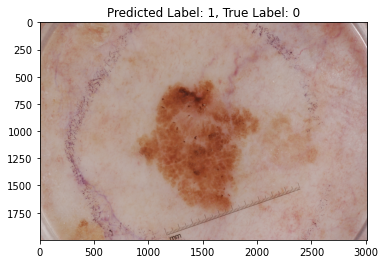

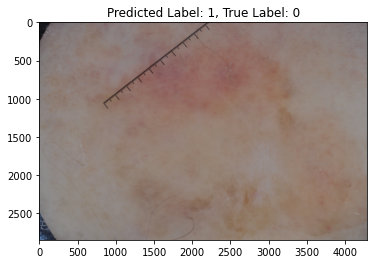

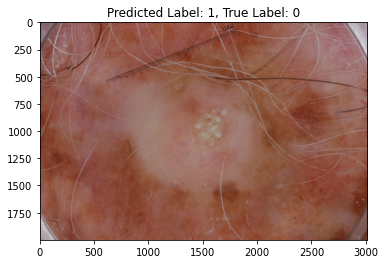

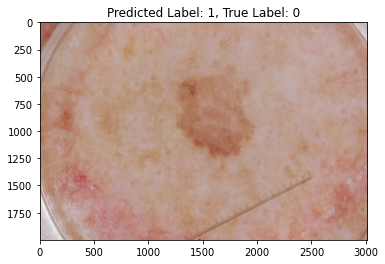

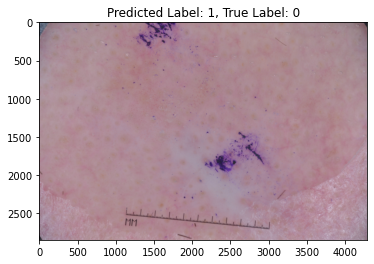

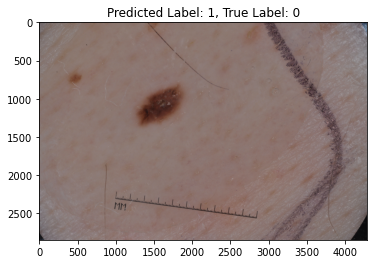

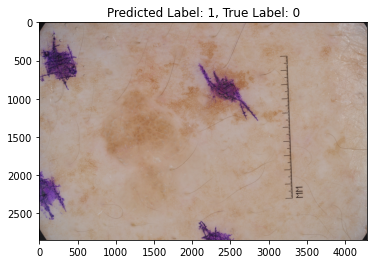

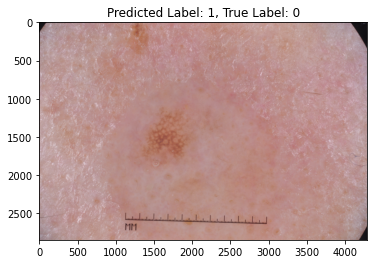

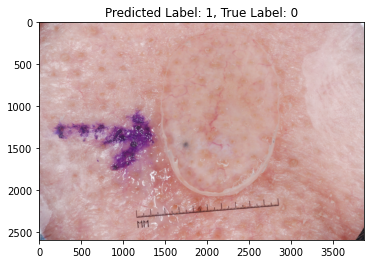

In [30]:
# Computation of Wrongly Classified Images
wrong_imageid=[]
id=[]
for i in range(len(labels_pred)):
    if labels_pred[i].item()!=int(testdf['label'][i]):#.astype(int).to_numpy():
        wrong_imageid.append(testdf['image_id'][i])
        id.append(i)
        
len(wrong_imageid)

import matplotlib.pyplot as plt
number=0
for i in id:
    number += 1
    if number>=10:
        break
    X=plt.imread('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Data\\'+wrong_imageid[i])
    plt.title('Predicted Label: ' + str(labels_pred[i].item()) + ', True Label: '+ str(testdf['label'][i]))
    plt.imshow(X.astype(np.uint8))
    plt.show()

    
